# 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model


# 2. Loading Data

In [ ]:
train_directory = "Face Mask Dataset/Train"
validation_directory = "Face Mask Dataset/Validation"
test_directory = "Face Mask Dataset/Test"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    channel_shift_range=50.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

validation_generator = test_val_datagen.flow_from_directory(
    validation_directory,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = test_val_datagen.flow_from_directory(
    test_directory,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


# 3. Augmintation Comparing

Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


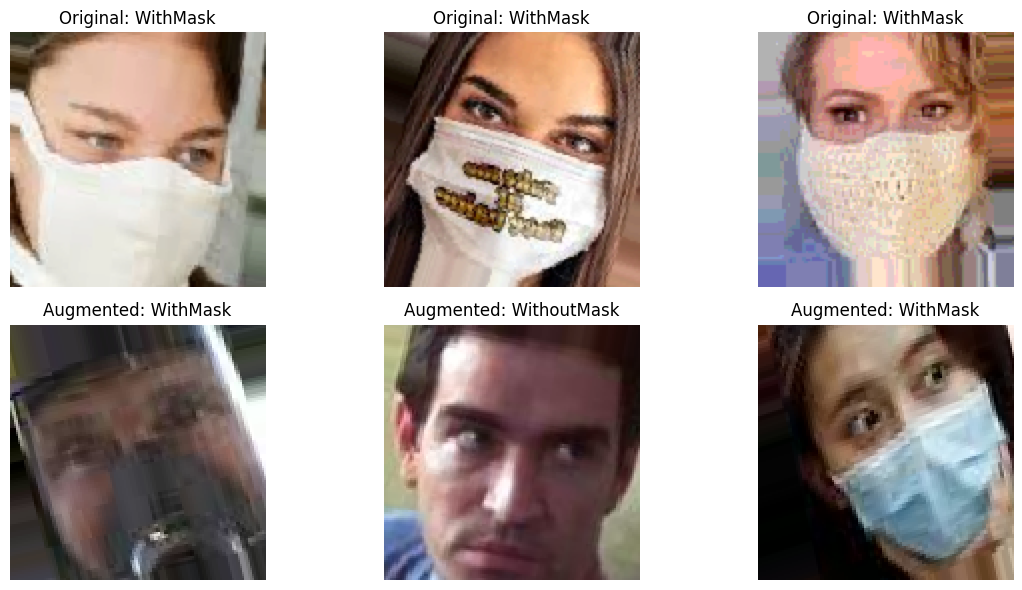

In [ ]:
no_aug_datagen = ImageDataGenerator(rescale=1./255)
no_aug_generator = no_aug_datagen.flow_from_directory(
    train_directory,
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    shuffle=True
)


original_images, original_labels = next(no_aug_generator)
aug_images, aug_labels = next(train_generator)

n = 3
plt.figure(figsize=(12, 6))

for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(original_images[i])
    label = "WithMask" if original_labels[i] == 0 else "WithoutMask"
    plt.title(f"Original: {label}")
    plt.axis('off')

for i in range(n):
    plt.subplot(2, n, i+1+n)
    plt.imshow(aug_images[i])
    label = "WithMask" if aug_labels[i] == 0 else "WithoutMask"
    plt.title(f"Augmented: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# 4. Model Build

In [7]:
base_model = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 72s 1us/step


In [8]:
base_model.trainable = False

In [9]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # تصنيف ثنائي: Mask / No Mask
])


In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Model Training

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
) 

c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.8331 - loss: 0.3804 - val_accuracy: 0.9762 - val_loss: 0.1108
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 292s 933ms/step - accuracy: 0.9343 - loss: 0.1847 - val_accuracy: 0.9900 - val_loss: 0.0538
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 299s 953ms/step - accuracy: 0.9569 - loss: 0.1362 - val_accuracy: 0.9937 - val_loss: 0.0374
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.9623 - loss: 0.1139 - val_accuracy: 0.9962 - val_loss: 0.0279
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.9668 - loss: 0.0998 - val_accuracy: 0.9975 - val_loss: 0.0230
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.9699 - loss: 0.0895 - val_accuracy: 0.9975 - val_loss: 0.0198
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9721 - loss: 0.0826 - val_accuracy: 0.9975 - val_loss: 0.0173
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9737 - loss: 0.0807 - va

# 6. Model Training

In [12]:

train_loss, train_acc = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_acc:.4f}")

val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9820 - loss: 0.0555
Training Accuracy: 0.9820
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 965ms/step - accuracy: 0.9987 - loss: 0.0129
Validation Accuracy: 0.9987
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 951ms/step - accuracy: 0.9919 - loss: 0.0195
Test Accuracy: 0.9919


# 7. Confusion Matrix

31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 939ms/step


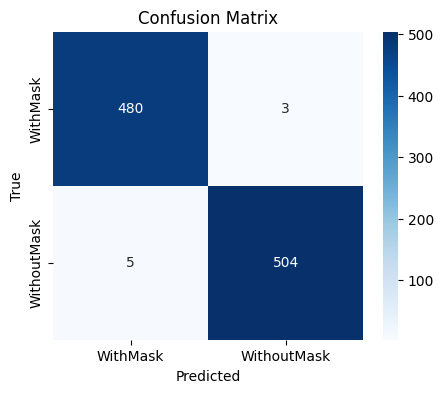

              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [14]:
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# القيم الحقيقية
y_true = test_generator.classes

# حساب الـ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# رسم الـ Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# تقرير شامل
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# 8. Model Saving

In [15]:
model.save("mask_DenseNet201_model.h5")

# 9. Face Detection

In [23]:
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model

# تحميل الموديل المدرب
model = load_model("mask_DenseNet201_model.h5")  # غير الاسم حسب الموديل بتاعك

# إنشاء كاشف الوجه MTCNN
detector = MTCNN()

# قراءة الصورة
image = cv2.imread("download1.jpeg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


faces = detector.detect_faces(image_rgb)

for face in faces:
    x, y, width, height = face['box']
    
    face_crop = image_rgb[y:y+height, x:x+width]
    face_resized = cv2.resize(face_crop, (128, 128))
    face_input = np.expand_dims(face_resized / 255.0, axis=0)  # Normalize
    
    
    pred = model.predict(face_input)[0][0]
    label = "No Mask" if pred > 0.5 else "Mask"
    color = (0, 0, 255) if pred > 0.5 else (0, 255, 0)
    
    cv2.rectangle(image, (x, y), (x + width, y + height), color, 2)
    cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)


cv2.imshow("Mask Detection", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [24]:
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model

# تحميل الموديل
model = load_model("mask_DenseNet201_model.h5")

# إنشاء كاشف الوجه
detector = MTCNN()

# فتح الكاميرا (0 = الكاميرا الافتراضية)
cap = cv2.VideoCapture(0)  # لو عايز فيديو بدل الكاميرا حط مسار الفيديو هنا

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # تحويل الألوان لـ RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # كشف الوجوه
    faces = detector.detect_faces(frame_rgb)
    
    for face in faces:
        x, y, width, height = face['box']
        
        # معالجة الأخطاء لو الإحداثيات سالبة
        x, y = max(0, x), max(0, y)
        
        # قص الوجه وتحجيمه
        face_crop = frame_rgb[y:y+height, x:x+width]
        if face_crop.size == 0:
            continue
        face_resized = cv2.resize(face_crop, (128, 128))
        face_input = np.expand_dims(face_resized / 255.0, axis=0)
        
        # التنبؤ
        pred = model.predict(face_input)[0][0]
        label = "No Mask" if pred > 0.5 else "Mask"
        color = (0, 0, 255) if pred > 0.5 else (0, 255, 0)
        
        # رسم النتيجة
        cv2.rectangle(frame, (x, y), (x + width, y + height), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    
    # عرض الفيديو
    cv2.imshow("Mask Detection - Live", frame)
    
    # للخروج اضغط q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 